# NOTEBOOK FOR DEFENSE TECHNQUES

In [1]:
%run Chinese_MNIST_preprocessing.ipynb


Skipping, found downloaded files in ".\chinese-mnist" (use force=True to force download)


In [2]:
# import of libraries
# file management libraries
import os
import pickle
import random

#libraries for data preprocessing
import numpy as np

#libraries for data visualization
import matplotlib.pyplot as plt


#libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F



In [3]:
def set_seed(seed):
    """
    Sets the seed for random number generators to ensure reproducibility.
    
    Parameters:
    seed (int): The seed value to be used.
    """
    torch.manual_seed(seed)  # Set the seed for PyTorch
    torch.cuda.manual_seed(seed)  # Set the seed for CUDA (GPU)
    torch.cuda.manual_seed_all(seed)  # Set the seed for all GPUs if using multiple GPUs
    np.random.seed(seed)  # Set the seed for NumPy (used for random number generation outside PyTorch)
    random.seed(seed)  # Set the seed for Python's random module

# Example of usage
set_seed(42)  # You can use any integer as a seed

# Prepating data format

It is very import when we use pytorch to well format the data (tensor, dataloader,...)

In [4]:
def prepare_set_data(set_set):
    """
    Prepare the image tensors and labels from a given dataset.

    Parameters:
    set_set (list): The dataset containing images and labels.

    Returns:
    set_img_tensors (torch.Tensor): The image tensors of the dataset.
    set_labels (torch.Tensor): The labels of the dataset.
    """
    set_images = []
    set_labels = []

    # Separate the labels and images from the dataset
    for i in range(len(set_set)):
        set_images.append(set_set[i][0])
        set_labels.append(int(set_set[i][1][-2:]) - 1)  # Subtract 1 here (so 0 corresponds to 01, 1 to 02, etc.) because the loss function expects 0-starting labels

    set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)
    set_labels = torch.tensor(set_labels, dtype=torch.long)

    return set_img_tensors, set_labels


In [5]:
# Load the training and testing datasets in tensors format (images and labels) 
test_img_tensors, test_labels = prepare_set_data(test_set)
train_img_tensors, train_labels = prepare_set_data(train_set)

C:\Users\choho\AppData\Local\Temp\ipykernel_17344\2317009855.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  set_img_tensors = torch.tensor(set_images, dtype=torch.float32).permute(0, 3, 1, 2)


In [6]:
# Put into dataloader because we will use mini-batch gradient descent

# TRAINING SET
train_dataset = TensorDataset(train_img_tensors, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

# TEST SET
test_dataset = TensorDataset(test_img_tensors, test_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# 1. BASELINE CNN Model for Chiness-Mnist

We define a CNN using built-in function of Pytorch for computation efficiency (Use of GPU, TPU) instead of using numpy from scratch which will have cause us take a
long time for computation (even with library like numba for accelerating numpy)

### 1.1 Define the CNN model using a python Class 

In [7]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()

        # Define the convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the input size of the first linear layer based on the output of the convolutional layers
        self.fc1_input_size = 32 * 16 * 16  # 32 channels, 16x16 size after max-pooling

        # Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(self.fc1_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1) 
        x = self.classifier(x)
        return x

In [8]:
# Create an instance of the model
model = CNNModel(num_classes=15)

# Print the model
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)


### 1.2 Training the CNN model

In [9]:
# Training function 
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'train_loss': total_loss / len(dataloader),
        'train_acc': total_correct / total_samples,
    }

# Validation function 
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            
    return {'output': outputs,  # Pour afficher les prédictions sur le dernier lot
        'val_loss': total_loss / len(dataloader),
        'val_acc': total_correct / total_samples,
    }



In [34]:

skip_or_not_training = True  # Set this to True if you want to skip training and load the model directly


if skip_or_not_training:
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Training and evaluation of the model on several epochs 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 50
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Define the optimizer


    # Training and evaluation of the model on several epochs 
    for epoch in range(num_epochs):
        train_result = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_result = validate_one_epoch(model, test_loader, loss_fn, device)

        # Display of results for each epoch 
        print(f'Époque {epoch+1}/{num_epochs}')
        print(f'Entraînement - Perte: {train_result["train_loss"]:.4f}, Accuracy: {train_result["train_acc"]:.4f}')
        print(f'Validation - Perte: {val_result["val_loss"]:.4f}, Accuracy: {val_result["val_acc"]:.4f}')


    # saving the model 
    torch.save(model.state_dict(), 'baseline_model.pth')

    # load the model 
    model = CNNModel(num_classes=15)
    model.load_state_dict(torch.load('baseline_model.pth'))
    model.eval()


Époque 1/2
Entraînement - Perte: 0.7357, Accuracy: 0.8140
Validation - Perte: 0.3912, Accuracy: 0.8743
Époque 2/2
Entraînement - Perte: 0.2486, Accuracy: 0.9263
Validation - Perte: 0.2022, Accuracy: 0.9380


Époque 1/50
Entraînement - Perte: 0.0669, Accuracy: 0.9847
Validation - Perte: 0.1495, Accuracy: 0.9567
Époque 2/50
Entraînement - Perte: 0.1496, Accuracy: 0.9725
Validation - Perte: 0.2051, Accuracy: 0.9457
Époque 3/50
Entraînement - Perte: 0.0526, Accuracy: 0.9908
Validation - Perte: 0.1454, Accuracy: 0.9600
Époque 4/50
Entraînement - Perte: 0.0376, Accuracy: 0.9933
Validation - Perte: 0.1605, Accuracy: 0.9543
Époque 5/50
Entraînement - Perte: 0.0211, Accuracy: 0.9957
Validation - Perte: 0.1305, Accuracy: 0.9623
Époque 6/50
Entraînement - Perte: 0.0132, Accuracy: 0.9985
Validation - Perte: 0.1422, Accuracy: 0.9597
Époque 7/50
Entraînement - Perte: 0.0101, Accuracy: 0.9988
Validation - Perte: 0.1326, Accuracy: 0.9653
Époque 8/50
Entraînement - Perte: 0.0097, Accuracy: 0.9983
Validation - Perte: 0.1392, Accuracy: 0.9617
Époque 9/50
Entraînement - Perte: 0.0070, Accuracy: 0.9990
Validation - Perte: 0.1388, Accuracy: 0.9623
Époque 10/50
Entraînement - Perte: 0.0049, Accuracy: 0.9998
Vali

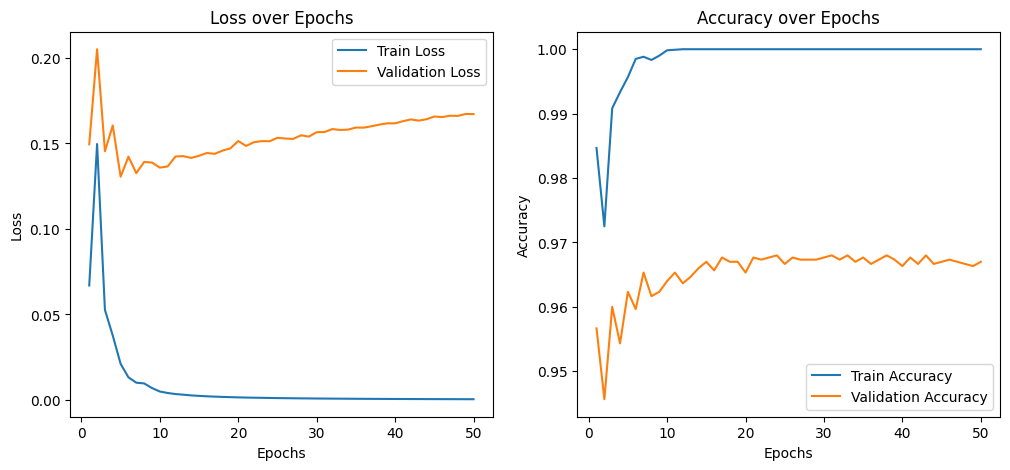

In [37]:

skip_or_not_training = True  # Set this to True if you want to skip training and load the model directly

if skip_or_not_training:
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Training and evaluation of the model on several epochs 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 50
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Define the optimizer

    # for storing the results
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Training and evaluation of the model on several epochs 
    for epoch in range(num_epochs):
        train_result = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_result = validate_one_epoch(model, test_loader, loss_fn, device)

        # store the results
        train_losses.append(train_result["train_loss"])
        train_accuracies.append(train_result["train_acc"])
        val_losses.append(val_result["val_loss"])
        val_accuracies.append(val_result["val_acc"])

        # Display of results for each epoch 
        print(f'Époque {epoch+1}/{num_epochs}')
        print(f'Entraînement - Perte: {train_result["train_loss"]:.4f}, Accuracy: {train_result["train_acc"]:.4f}')
        print(f'Validation - Perte: {val_result["val_loss"]:.4f}, Accuracy: {val_result["val_acc"]:.4f}')

    # draw the plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # saving the model 
    torch.save(model.state_dict(), 'baseline_model.pth')

In [38]:
# load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=15)
model.load_state_dict(torch.load('results/baseline_model.pth'))
model.eval()


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=15, bias=True)
  )
)

In [12]:
def get_all_predictions(model, dataloader, device):
    """ function to get all predictions of a model on a dataset 
    parameters: 
    model: the model to use for prediction
    dataloader: the dataset to predict
    device: the device to use for prediction
    returns:
    all_predictions: the predictions of the model on the dataset
    """
    
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels


In [13]:
# Use the function to obtain predictions on the test data set
test_predictions, test_labels = get_all_predictions(model, test_loader, device)

# Use the function to obtain predictions on the test data set
print("Prédictions:", test_predictions)
print("Étiquettes réelles:", test_labels)

Prédictions: [11, 14, 9, 3, 9, 2, 4, 6, 9, 4, 8, 1, 11, 11, 7, 12, 13, 5, 1, 6, 14, 3, 11, 2, 14, 11, 10, 14, 1, 2, 7, 14, 9, 12, 3, 3, 5, 10, 13, 6, 7, 0, 6, 6, 2, 5, 12, 13, 1, 3, 6, 2, 9, 0, 14, 12, 0, 7, 8, 10, 13, 12, 8, 14, 3, 5, 7, 3, 2, 11, 12, 14, 1, 10, 4, 1, 3, 1, 11, 12, 2, 2, 7, 8, 4, 14, 0, 5, 4, 4, 12, 10, 0, 7, 14, 2, 0, 10, 14, 8, 5, 8, 5, 2, 3, 1, 1, 2, 9, 0, 13, 10, 1, 3, 9, 3, 4, 7, 13, 12, 11, 0, 5, 11, 2, 11, 2, 4, 7, 12, 11, 7, 9, 12, 3, 3, 5, 5, 8, 5, 3, 1, 0, 0, 9, 9, 14, 11, 9, 14, 4, 14, 1, 8, 2, 5, 3, 11, 13, 7, 5, 2, 10, 12, 11, 13, 13, 11, 12, 4, 11, 3, 14, 13, 8, 0, 8, 0, 3, 10, 4, 3, 7, 9, 1, 12, 0, 7, 8, 8, 14, 12, 11, 3, 3, 1, 5, 6, 7, 12, 6, 7, 6, 12, 6, 1, 12, 1, 11, 10, 11, 9, 9, 0, 11, 8, 5, 1, 6, 1, 6, 6, 13, 5, 4, 1, 4, 11, 2, 11, 5, 0, 9, 0, 6, 1, 12, 4, 11, 14, 3, 6, 8, 3, 5, 7, 0, 11, 13, 6, 14, 7, 1, 14, 8, 11, 14, 1, 11, 13, 2, 7, 5, 12, 9, 10, 6, 8, 8, 1, 2, 9, 14, 10, 4, 2, 11, 9, 14, 3, 10, 10, 13, 9, 7, 0, 3, 5, 13, 14, 7, 0, 5, 14, 14, 

# 2. ATTAQUE METHODS apply to dataset

# 2.1 Fast Sign Gradient Methods

In [14]:
# Definition of the FGSM function 
def FGSM(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [15]:
# Loading of the training data 
train_img_tensors, train_labels = prepare_set_data(train_set)
train_img_tensors.requires_grad = True

# Loading of the test data 
test_img_tensors, test_labels = prepare_set_data(test_set)
test_img_tensors.requires_grad = True


In [16]:
# Parameters of the attack 
epsilon = 0.01

# Run images through the model and calculate losses 
outputs_test = model(test_img_tensors.to(device))
loss = F.cross_entropy(outputs_test, test_labels.to(device))

# Reset existing gradients in the model to zero and perform backpropagation 
model.zero_grad()
loss.backward()

# Collecting gradients from input images 
data_grad = test_img_tensors.grad.data

# Aply FGSM on test images 
perturbed_data_test_fgsm = FGSM(test_img_tensors, epsilon, data_grad)


# Run training images through the model and calculate losses 
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Reset the existing gradients in the model and backpropagate the training images 
model.zero_grad()
loss_train.backward()

# Collecting gradients in relation to training images 
data_grad_train = train_img_tensors.grad.data

# Apply FGSM to training images 
perturbed_data_train_fgsm = FGSM(train_img_tensors, epsilon, data_grad_train)



In [17]:

# Assessing the model on adversarial images
output = model(perturbed_data_test_fgsm.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())

# Assessing the model on the training adversarial images
output_train = model(perturbed_data_train_fgsm.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())




Test accuracy on adversarial images: 0.6466666460037231

Training accuracy on adversarial images: 0.6489999890327454


# 2.2 Projected_gradient_descent 

In [18]:
def pgd_attack(model, img, labels, eps, alpha, num_iter):
    # Copies the image and ensures that gradients can be calculated
    img_disturbed = img.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        # Resets gradients 
        if img_disturbed.grad is not None:
            img_disturbed.grad.data.zero_()

        # Calculates the loss 
        predictions = model(img_disturbed)
        loss = F.cross_entropy(predictions, labels)

        # Calculates gradients 
        loss.backward()

        # Applies the PGD attack 
        with torch.no_grad():
            img_disturbed.data += alpha * img_disturbed.grad.data.sign()
            img_disturbed.data = torch.clamp(img_disturbed.data, min=img.data - eps, max=img.data + eps)
            img_disturbed.data = torch.clamp(img_disturbed.data, min=0, max=1)

    return img_disturbed


In [19]:
# Apply PGD to training images 
epsilon = 0.1  
alpha = 0.01 
num_iter = 2 

# Run images through the model and calculate losses 
outputs_test = model(test_img_tensors.to(device))
loss = F.cross_entropy(outputs_test, test_labels.to(device))

# Reset existing gradients in the model to zero and perform backpropagation 
model.zero_grad()
loss.backward()

# Collecting gradients from input images 
data_grad = test_img_tensors.grad.data

# Aply PGD on test images 
perturbed_data_test_pgd = pgd_attack(model, test_img_tensors, test_labels, epsilon, alpha, num_iter)


# Run training images through the model and calculate losses 
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Reset the existing gradients in the model and backpropagate the training images 
model.zero_grad()
loss_train.backward()

# Collecting gradients in relation to training images 
data_grad_train = train_img_tensors.grad.data

# Apply PGD to training images 
perturbed_data_train_pgd = pgd_attack(model, train_img_tensors, train_labels, epsilon, alpha, num_iter)



In [20]:

# Assessing the model on adversarial images
output = model(perturbed_data_test_pgd.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())

# Assessing the model on the training adversarial images
output_train = model(perturbed_data_train_pgd.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())




Test accuracy on adversarial images: 0.6193333268165588

Training accuracy on adversarial images: 0.6155833601951599


# 2.3 Carlini&Wagner


In [21]:

def cw_attack(model, img, label, eps, lr, max_iter):
    # Initialisation
    w = torch.zeros_like(img, requires_grad=True)
    optimizer = torch.optim.Adam([w], lr=lr)

    for _ in range(max_iter):
        new_img = 0.5 * (torch.tanh(w) + 1)
        output = model(new_img)
        _, predicted = torch.max(output, 1)

        # Calculating losses 
        real = torch.max(predicted * label)
        other = torch.max(predicted * (1 - label))
        loss1 = torch.clamp(other - real, min=0)
        loss2 = torch.norm(new_img.view(new_img.size(0), -1) - img.view(img.size(0), -1), p=2)
        loss = eps * loss1 + loss2

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    adv_img = 0.5 * (torch.tanh(w) + 1)
    return adv_img


In [22]:
# Apply PGD to training images 
epsilon = 0.1  
lr = 0.01
max_iter = 2

# Run images through the model and calculate losses 
outputs_test = model(test_img_tensors.to(device))
loss = F.cross_entropy(outputs_test, test_labels.to(device))

# Reset existing gradients in the model to zero and perform backpropagation 
model.zero_grad()
loss.backward()

# Collecting gradients from input images 
data_grad = test_img_tensors.grad.data

# Aply PGD on test images 
perturbed_data_test_cw = cw_attack(model, test_img_tensors, test_labels, epsilon, lr, max_iter) 


# Run training images through the model and calculate losses 
outputs_train = model(train_img_tensors.to(device))
loss_train = F.cross_entropy(outputs_train, train_labels.to(device))

# Reset the existing gradients in the model and backpropagate the training images 
model.zero_grad()
loss_train.backward()

# Collecting gradients in relation to training images 
data_grad_train = train_img_tensors.grad.data

# Apply PGD to training images 
perturbed_data_train_cw = cw_attack(model, train_img_tensors, train_labels, epsilon,lr, max_iter)


In [23]:

# Assessing the model on adversarial images
output = model(perturbed_data_test_cw.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())

# Assessing the model on the training adversarial images
output_train = model(perturbed_data_train_cw.to(device))
final_loss_train = F.cross_entropy(output_train, train_labels.to(device))
final_acc_train = (output_train.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTraining accuracy on adversarial images:', final_acc_train.item())




Test accuracy on adversarial images: 0.06666667014360428

Training accuracy on adversarial images: 0.06666667014360428


# 3. Visualisation of the attacks

In [ ]:
#displays an image before and after disruption
import matplotlib.pyplot as plt
import numpy as np

# Defining the function for displaying an image
def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

#Definition of the function for displaying an image before and after disturbance
def show_images(image, perturbed_image):
    img = image[0]
    perturbed_img = perturbed_image[0]
    imshow(img.cpu())
    imshow(perturbed_img.cpu())

# Display an image before and after disturbance
show_images(test_img_tensors, perturbed_data_test_fgsm)
show_images(test_img_tensors, perturbed_data_test_pgd)


# II. Apply defence Techniques

- II - 1 . Implementation 1 of Adversariables Training (Goodfellow et al.(2015)) 
- II - 2 . Implementation 2 of Adversariables Training (Goodfellow et al.(2015))
- II - 3 . Implemtation of Defensive GAN (Samangouei et al. (2018))


## II - 1 . Implementation 1 of Adversariables Training (Goodfellow et al.(2015)) 


$$

\theta^* = arg\min_{\theta}  \lambda  J(\theta, x, y) + (1-\lambda)  J(\theta, x', y) 

$$

In [24]:
def adversarial_loss(model, clean_data, adversary_data, labels, alpha, loss_fn, device):
    # Calculation of the loss on clean examples
    clean_outputs = model(clean_data)
    clean_loss = loss_fn(clean_outputs, labels)

    # Calculating the loss on adversarial examples
    adversary_outputs = model(adversary_data)
    adversary_loss = loss_fn(adversary_outputs, labels)

    # Combination of the two losses 
    combined_loss = alpha * clean_loss + (1 - alpha) * adversary_loss
    return combined_loss


In [25]:
# Definition of the function for evaluating performance on perturbed_data_test
def validate_perturbed(model, perturbed_data_test, test_labels, device):
    model.eval()
    total_correct = 0
    total_samples = perturbed_data_test.shape[0]
    
    with torch.no_grad():
        # Make sure that perturbed_data_test is on the correct device
        perturbed_data_test = perturbed_data_test.to(device)
        test_labels = test_labels.to(device)
        
        # Run the disturbed images through the model
        outputs = model(perturbed_data_test)
        _, predicted = torch.max(outputs, 1)
        total_correct = (predicted == test_labels).sum().item()
    
    accuracy = total_correct / total_samples
    return accuracy


In [30]:
def validate_model(model, dataloader, device):
    """ function to evaluate the performance of a model on a dataset"""
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    return accuracy


In [41]:
# List of different lambda values to test
#lambda_values = np.linspace(0, 1, num=5)  # for example: 0, 0.25, 0.5, 0.75, 1
lambda_values = [0.25,0.5]
# Dictionary to save accuracies and losses for each lambda value
lambda_results = {}
num_epochs = 2

for lambda_value in lambda_values:
    # Reset the model and optimizer
    model = CNNModel(num_classes=15)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    # Lists to store loss and accuracies for each epoch
    epoch_losses = []
    epoch_accuracies = []
    epoch_fgsm_accuracies = []
    epoch_pgd_accuracies = []
    epoch_cw_accuracies = []

    # Train the model with the current lambda value
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            # Create adversarial examples with FGSM
            images.requires_grad = True
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            model.zero_grad()
            loss.backward()
            images_grad = images.grad.data
            perturbed_images = FGSM(images, epsilon, images_grad)
            
            # Calculate mixed loss and update weights
            model.zero_grad()
            loss = adversarial_loss(model, images, perturbed_images, labels, lambda_value, F.cross_entropy, device)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Calculate average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        # Evaluate the model on different test datasets
        normal_accuracy = validate_model(model, test_loader, device)
        fgsm_accuracy = validate_perturbed(model, perturbed_data_test_fgsm, test_labels, device)
        pgd_accuracy = validate_perturbed(model, perturbed_data_test_pgd, test_labels, device)
        cw_accuracy = validate_perturbed(model, perturbed_data_test_cw, test_labels, device)

        epoch_accuracies.append(normal_accuracy)
        epoch_fgsm_accuracies.append(fgsm_accuracy)
        epoch_pgd_accuracies.append(pgd_accuracy)
        epoch_cw_accuracies.append(cw_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} completed for lambda={lambda_value:.2f}. Loss: {avg_loss:.4f}")

    # Store the collected data
    lambda_results[lambda_value] = {
        "losses": epoch_losses,
        "normal_accuracies": epoch_accuracies,
        "fgsm_accuracies": epoch_fgsm_accuracies,
        "pgd_accuracies": epoch_pgd_accuracies,
        "cw_accuracies": epoch_cw_accuracies
    }

    print(f"Results for lambda={lambda_value:.2f}: Normal Acc: {normal_accuracy:.4f}, FGSM Acc: {fgsm_accuracy:.4f}, PGD Acc: {pgd_accuracy:.4f}, CW Acc: {cw_accuracy:.4f}")


Epoch 1/2 completed for lambda=0.25. Loss: 2.4223
Epoch 2/2 completed for lambda=0.25. Loss: 2.1768
Results for lambda=0.25: Normal Acc: 0.8277, FGSM Acc: 0.4397, PGD Acc: 0.4357, CW Acc: 0.0937
Epoch 1/2 completed for lambda=0.50. Loss: 2.1280
Epoch 2/2 completed for lambda=0.50. Loss: 1.6360
Results for lambda=0.50: Normal Acc: 0.8287, FGSM Acc: 0.3893, PGD Acc: 0.3857, CW Acc: 0.0667


### II - 1.2 Visualization

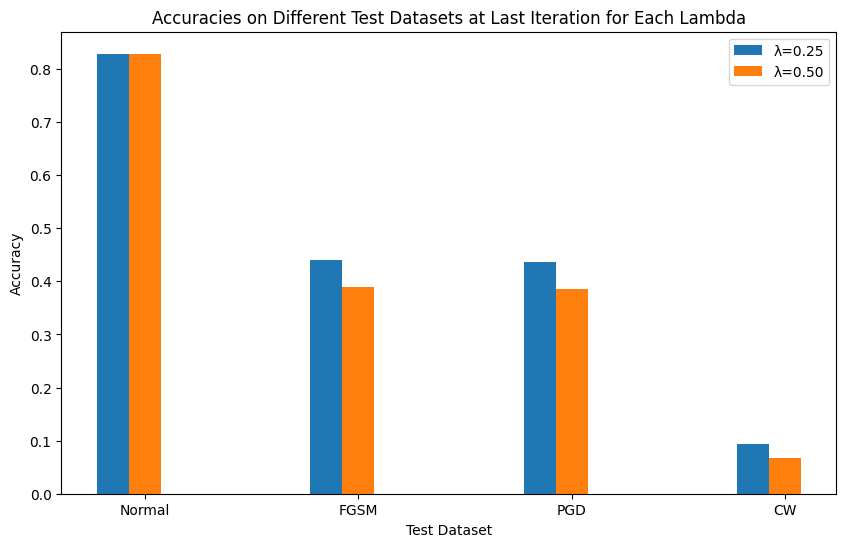

In [44]:
# Plotting the results at the last iteration for each lambda value
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = np.arange(len(lambda_results[next(iter(lambda_results))]) - 1)  # Number of test datasets (excluding losses)

# Loop through each lambda value
for i, (lambda_value, results) in enumerate(lambda_results.items()):
    normal_acc = results['normal_accuracies'][-1]
    fgsm_acc = results['fgsm_accuracies'][-1]
    pgd_acc = results['pgd_accuracies'][-1]
    cw_acc = results['cw_accuracies'][-1]

    plt.bar(index + bar_width * i, [normal_acc, fgsm_acc, pgd_acc, cw_acc], bar_width, label=f'λ={lambda_value:.2f}')

plt.xlabel('Test Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracies on Different Test Datasets at Last Iteration for Each Lambda')
plt.xticks(index + bar_width, ['Normal', 'FGSM', 'PGD', 'CW'])
plt.legend()

In [ ]:
# Tuning of lamda parameter for the example
lambda_values = list(lambda_accuracies.keys())  # Simulated lambda values, ranging from 0.0 to 1.0
accuracy_values = [accuracy[0] for accuracy in lambda_accuracies.values()]  # Simulated accuracy for each lambda value
perturbed_accuracy_values = [accuracy[1] for accuracy in lambda_accuracies.values()]  # Simulated perturbed accuracy for each lambda value

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, accuracy_values, marker='o', linestyle='-', color='blue', label='Validation Accuracy')
plt.plot(lambda_values, perturbed_accuracy_values, marker='o', linestyle='-', color='red', label='Perturbed Accuracy')

# Titles and labels
plt.title('Effect of Lambda on Validation Accuracy and Perturbed Accuracy')
plt.xlabel('Lambda Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


The best lamda value (weighing factor) is around 0.5 like in (Goodfellow et al.(2015))

## - II - 2 . Implementation 2 of Adversariables Training (Goodfellow et al.(2015))
Idea : trains the model on both the original data and adversarial examples generated from the original data in an alternating manner.( adverse --> originale -->adverse --> ...)

In [ ]:
def adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs):
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Creating adversarial examples with FGSM 
            images.requires_grad = True
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            perturbed_images = FGSM(images, epsilon, data_grad)

            # Training with original data 
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Training with adversarial  data
            optimizer.zero_grad()
            outputs_adv = model(perturbed_images)
            loss_adv = loss_fn(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
    return model

# Parameters 
epsilon = 0.1  # Parameter for FGSM
num_epochs = 5  # Number of training epochs 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Adversarial training 
model_robust_1 = adversarial_training(model, train_loader, epsilon, optimizer, loss_fn, device, num_epochs)

# Save model 
torch.save(model_robust_1.state_dict(), 'results/model_robust_1.pth')




In [ ]:
# Load model 
model_robust_1 = CNNModel(num_classes=15)
model_robust_1.load_state_dict(torch.load('results/model_robust_1.pth'))
model_robust_1.eval()

# Evaluate the robust model on adversarial images 
output = model_robust_1(perturbed_data_test.to(device))
final_loss = F.cross_entropy(output, test_labels.to(device))
final_acc = (output.max(1)[1] == test_labels.to(device)).float().mean()
print('\nTest accuracy on adversarial images:', final_acc.item())



In [ ]:
# load the model 
#model_robust_1 = CNNModel(num_classes=15)
#model_robust_1.load_state_dict(torch.load('model_robust_1.pth'))
#model_robust_1.eval()

# Evaluate the robust model on adversarial images 
output = model_robust_1(perturbed_data_train.to(device))
final_loss = F.cross_entropy(output, train_labels.to(device))
final_acc = (output.max(1)[1] == train_labels.to(device)).float().mean()
print('\nTrain accuracy on adversarial images:', final_acc.item())


## - II - 3 . Implemtation of Defensive GAN (Samangouei et al. (2018))

 The strucutre of the code for **STANDARD GAN**  comme from the graded assignment from the "Deep Learning II: Master Data Science"
 course, completed by a member of our team (Double Cursus student ENSAE & Master Data science IP-paris).

 Primary Contributions:
 - The core implementation, which was subject to grading, was developed by the student.
   Although the overall code structure was inspired by the course instructor's template.

 - Personal enhancements include:
   - Correction and improvement of the original coursework.
   - Adaptation from Keras to PyTorch to maintain consistency across our project's codebase.
      (code from th assignment was initialy in Keras)

 Code Enhancement:
 - This code has been enhanced to align with the Defense-GAN (WGAN) approach, approache which is built 
   using a standard GAN.
   as introduced in the paper "DEFENSE-GAN: PROTECTING CLASSIFIERS AGAINST ADVERSARIAL ATTACKS USING
   GENERATIVE MODELS" by Pouya Samangouei, Maya Kabkab, and Rama Chellappa (2018).

The code 2.Defence GAN also come from us 

# 1. STANDARD GAN

In [ ]:

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        validity = self.model(flattened)
        return validity

class GAN():
    def __init__(self, dataset_name='mnist'):
        # Load data
        self.img_shape = (1, 64, 64)  # for MNIST
        self.z_dim = 100
        self.dataset_name = dataset_name
        self.model_file = f'models/{self.dataset_name}_gan_model.pickle'

        # Define networks
        self.generator = Generator(self.z_dim, self.img_shape)
        self.discriminator = Discriminator(self.img_shape)

        # Optimizers
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Loss function
        self.adversarial_loss = nn.BCELoss()

    def load_gan_data(self):
        # MNIST Dataset
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        return dataloader

    def train(self, epochs, train_loader, sample_interval=1000):
        for epoch in range(epochs):
            for i, (imgs, _) in enumerate(train_loader):
                # Adversarial ground truths
                valid = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
                fake = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(torch.FloatTensor))

                # -----------------
                #  Train Generator
                # -----------------
                self.optimizer_G.zero_grad()

                # Sample noise as generator input
                z = Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.size(0), self.z_dim))))

                # Generate a batch of images
                gen_imgs = self.generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                self.optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples
                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

                # If at save interval => save generated image samples and model checkpoints
                if i % sample_interval == 0:
                    # Save image samples
                    # Save model checkpoints                    
                    self.save_sample_images(epoch, i)
                    torch.save(self.generator.state_dict(), f'results/generator_epoch{epoch}_batch{i}.pth')
                    torch.save(self.discriminator.state_dict(), f'results/discriminator_epoch{epoch}_batch{i}.pth')                
                
    def save_sample_images(self, epoch, batch):
        # Generate noise
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (25, self.z_dim))))

        # Generate images from noise
        gen_imgs = self.generator(z).detach()

        # Rescale images from [-1, 1] to [0, 1] range
        gen_imgs = (gen_imgs + 1) / 2

        # Save image grid
        save_image(gen_imgs.data, f'results/epoch{epoch}_batch{batch}.png', nrow=5, normalize=True)


In [ ]:
# Assume test_data is already defined and processed by your prepared_data function
# from standard_GAN import GAN

gan = GAN()
gan.train(epochs=1, train_loader=train_dataset)


In [ ]:
# Assume test_data is already defined and processed by your prepared_data function
gan_2 = GAN()
gan_2.train(epochs=1, train_loader=test_dataset, sample_interval=1000)


# 2. DEFENCE GAN



![algorithm](utils/algo_defence_GAN.png)



In [ ]:
# Function to optimize the latent vector
def optimize_latent_vector(generator, input_img, latent_dim, device, steps=20, lr=0.01):
    """
    Optimizes the latent vector 'z' of the generator to reconstruct the input image.
    
    Parameters:
    generator (torch.nn.Module): The generator model that takes a latent vector 'z'.
    input_img (torch.Tensor): The image to be reconstructed by the generator.
    latent_dim (int): The dimensionality of the latent space.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    steps (int): The number of optimization steps.
    lr (float): The learning rate for the optimizer.
    
    Returns:
    torch.Tensor: The optimized latent vector 'z'.
    """
    set_seed(42) 
    # Move the input image to the specified device
    input_img = input_img.to(device)
    
    # Initialize the latent vector with random noise and enable gradient computation
    z = Variable(torch.randn(1, latent_dim).to(device), requires_grad=True)
    
    # Set up the optimizer for the latent vector
    optimizer = torch.optim.Adam([z], lr=lr)

    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()  # Clear previous gradients
        reconstructed_img = generator(z).squeeze(1)  # Generate the reconstructed image
        loss = F.mse_loss(reconstructed_img, input_img)  # Compute the MSE loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update the latent vector 'z'

    return z.detach()  # Detach 'z' from the computation graph and return

# Function to reconstruct the image and classify
def defense_gan_classifier(generator, classifier, input_img, latent_dim, device):
    """
    Uses DefenseGAN approach to reconstruct the image using the generator and then classifies it using the classifier.
    
    Parameters:
    generator (torch.nn.Module): The generator model for image reconstruction.
    classifier (torch.nn.Module): The classifier model for predicting the class.
    input_img (torch.Tensor): The input image to be reconstructed and classified.
    latent_dim (int): The dimensionality of the latent space.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    
    Returns:
    tuple: A tuple containing the reconstructed image, predictions, and labels.
    """
    set_seed(42) 
    # Optimize the latent vector to reconstruct the input image
    optimized_z = optimize_latent_vector(generator, input_img, latent_dim, device)
    
    # Reconstruct the image using the optimized latent vector
    reconstructed_img = generator(optimized_z).squeeze(1)  # Remove extra dimension

    # Prepare the reconstructed image for classification
    reconstructed_img_for_classifier = reconstructed_img.unsqueeze(0)  # Add batch dimension if needed

    # Classify the reconstructed image
    classifier.eval()
    with torch.no_grad():
        output = classifier(reconstructed_img_for_classifier.to(device))
        predicted = output.max(1)[1]  # Get the index of the max log-probability

    return reconstructed_img, predicted.item()




In [ ]:
def find_latent_dim(generator):
    """find the latent dimension of the generator"""
    for module in generator.modules():
        if isinstance(module, nn.Linear):
            # La dimension de l'espace latent est le nombre de features en entrée de la première couche linéaire
            return module.in_features
    return None


In [ ]:
# using it on the test data
Generator = gan_2.generator
latent_dim = find_latent_dim(Generator)
input_img = test_img_tensors[1]  # Image d'entrée à défendre
reconstructed_img, prediction = defense_gan_classifier(Generator, model, input_img, latent_dim, device)

print("Prédiction:", prediction)

In [ ]:
def evaluate_accuracy_with_defensegan(generator, classifier, data, labels, latent_dim, device):
    """
    Evaluates the accuracy of a classifier model using DefenseGAN for image reconstruction.
    
    Parameters:
    generator (torch.nn.Module): The generator model from DefenseGAN.
    classifier (torch.nn.Module): The classifier model to be evaluated.
    perturbed_data (torch.Tensor): The adversarial (perturbed) images.
    labels (torch.Tensor): The true labels of the images.
    latent_dim (int): The dimensionality of the latent space in DefenseGAN.
    device (torch.device): The device (CPU/GPU) on which the computation will be performed.
    
    Returns:
    float: The accuracy of the classifier on the reconstructed images.
    """
    correct = 0
    total = 0

    for i in range(data.size(0)):
        input_img = data[i]  # Image d'entrée à défendre
        reconstructed_img, prediction = defense_gan_classifier(generator, classifier, input_img, latent_dim, device)

        # evaluate the model on the reconstructed image
        correct += (prediction == labels[i].item())

    return correct / labels.size(0)


In [ ]:
accuracy_test_defencegan = evaluate_accuracy_with_defensegan(Generator, model,test_img_tensors, test_labels, latent_dim, device)
accuracy_test_defencegan